In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers seqeval[gpu] -q
!pip install fairseq -q
!pip install fastBPE -q
!pip install pytorch-crf -q

In [ ]:
%cd /content/drive/MyDrive/NLP/project_nlp

/content/drive/MyDrive/NLP/project_nlp


### Import

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torchcrf import CRF

from transformers import RobertaConfig, RobertaPreTrainedModel, RobertaModel, RobertaForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from transformers.modeling_outputs import TokenClassifierOutput

import seqeval
from seqeval.metrics import classification_report, f1_score

import pandas as pd
import numpy as np
import argparse
import time
import tqdm
from sklearn import metrics

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

from sklearn.utils.class_weight import compute_class_weight

from src.dataset import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Parameters


In [ ]:
BATCHSIZE_TRAIN = 8
BATCHSIZE_VAL = 4
LEARNING_RATE = 3e-5
MAX_LEN = 128
NUM_EPOCH = 20
SEED = 42
NUM_CLASS = 5
MAX_GRAD_NORM = 1

### Data

In [ ]:
data = pd.read_csv('./data/joint/data_joint.csv')
print(data)

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="./PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")

labels_to_ids = {'B-DES': 1, 'B-PRI': 3, 'I-DES': 2, 'I-PRI': 4, 'O': 0, 'X': -100}
ids_to_labels = {0: 'O', 1: 'B-DES', 2: 'I-DES', 3:'B-PRI', 4:'I-PRI'}

X, Y_label, Y_mask = convert_lines(
    data.sentence.values, 
    data.word_labels.values, 
    vocab, 
    bpe, 
    labels_to_ids, 
    max_sequence_length=MAX_LEN)

convert_type = {-1: 0,
                0:1,
                1:2}
Y_sent = data['label'].map(convert_type).astype(int).values


print('X shape: ', X.shape)
print('Y label shape', Y_label.shape)
print('Y mask shape', Y_mask.shape)
print('Y sent shape', Y_sent.shape)

train_size = 0.8
def train_test_split(data, train_size):
    data_df = pd.DataFrame(data)
    data_train = data_df.sample(frac = train_size, random_state=SEED)
    data_test = data_df.drop(data_train.index).reset_index(drop=True)
    data_train = data_train.reset_index(drop=True)
    return data_train.values, data_test.values

X_train, X_test = train_test_split(X, train_size)
Y_label_train, Y_label_test = train_test_split(Y_label, train_size)
Y_mask_train, Y_mask_test = train_test_split(Y_mask, train_size)
Y_sent_train, Y_sent_test = train_test_split(Y_sent, train_size)

class_weight = compute_class_weight(
    class_weight='balanced', 
    classes = np.array([0,1,2,3,4]), 
    y=Y_label_train.flatten()[Y_label_train.flatten()>=0])

print('class_weight for sequence labeling using CrossEntropyLoss', class_weight)


train_dataset = TensorDataset(
    torch.tensor(X_train,dtype=torch.long), 
    torch.tensor(Y_label_train,dtype=torch.long),
    torch.tensor(Y_sent_train,dtype=torch.long)
    )
valid_dataset = TensorDataset(
    torch.tensor(X_test,dtype=torch.long), 
    torch.tensor(Y_label_test,dtype=torch.long),
    torch.tensor(Y_sent_test,dtype=torch.long)
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCHSIZE_TRAIN, 
    shuffle=True,
    drop_last=True
    )
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=BATCHSIZE_VAL, 
    shuffle=False,
    drop_last=True
    )

      Unnamed: 0  ... label
0              0  ...    -1
1              1  ...    -1
2              2  ...    -1
3              3  ...    -1
4              4  ...    -1
...          ...  ...   ...
3652        3652  ...     1
3653        3653  ...     1
3654        3654  ...     1
3655        3655  ...     1
3656        3656  ...     1

[3657 rows x 4 columns]


100%|██████████| 3657/3657 [00:00<00:00, 3856.55it/s]

X shape:  (3657, 128)
Y label shape (3657, 128)
Y mask shape (3657, 128)
Y sent shape (3657,)
class_weight for sequence labeling using CrossEntropyLoss [ 0.24363978  1.55168755  6.34937644 16.17223529 31.45629291]


### Config

In [ ]:
class argu():
    def __init__(self):
        self.dict_path = "./PhoBERT_base_transformers/dict.txt"
        self.config_path = "./PhoBERT_base_transformers/config.json"
        self.max_sequence_length = MAX_LEN
        self.accumulation_steps = 1
        self.epochs = NUM_EPOCH
        self.seed = SEED
        self.bpe_codes = "./PhoBERT_base_transformers/bpe.codes"
args = argu()

config = RobertaConfig.from_pretrained(
    args.config_path,
    output_hidden_states=True,
    return_dict=True,
    num_labels=NUM_CLASS,
    pad_token_id = 1,
    bos_token_id = 0,
    eos_token_id = 2,
    attention_probs_dropout_prob = 0.1,
    classifier_dropout=0.5,
    gradient_checkpointing=False,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    hidden_size=768,
    initializer_range=0.02,
    intermediate_size=3072,
    layer_norm_eps=1e-05,
    max_position_embeddings=258,
    model_type="roberta",
    num_attention_heads=12,
    num_hidden_layers=12,
    position_embedding_type="absolute",
    tokenizer_class="PhobertTokenizer",
    transformers_version="4.15.0",
    type_vocab_size=1,
    use_cache=True,
    vocab_size=64001
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


### Train test function

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
def train_crf(epoch, verbose = False):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    labels_sent_ar = []
    y_preds = None
    model.train()
    
    for idx, batch in enumerate(train_loader):
        ids, labels, labels_sent = batch
        ids = ids.to(device)
        labels = labels.to(device)
        labels_sent = labels_sent.to(device)
        mask = ids!=1
        
        outputs = model(input_ids=ids, 
                        attention_mask=mask, 
                        labels=labels, 
                        labels_sent=labels_sent)
        
        loss = outputs[0]
        y_pred = outputs[2].squeeze().detach().cpu().numpy()
        y_preds = np.atleast_1d(y_pred) if y_preds is None else np.concatenate([y_preds, np.atleast_1d(y_pred)])
                
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0 and verbose:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        flattened_predictions = outputs[1].view(-1)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)
        labels_sent_ar.extend(labels_sent.cpu().detach().numpy())
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        try: 
            scheduler0.step()
        except:
            scheduler.step()
            
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    labels = [ids_to_labels[id.item()] for id in tr_labels]
    predictions = [ids_to_labels[id.item()] for id in tr_preds]

    f1_token = seqeval.metrics.f1_score([labels], [predictions])
    val_preds = np.argmax(softmax(y_preds), axis=1)
    # print(val_preds)
    # print(np.concatenate(labels_sent_ar))
    f1_sent = metrics.f1_score(labels_sent_ar, val_preds, average='micro')

    print(f"Train loss: {epoch_loss}", 
          f"F1 tagging: {f1_token}", 
          f"F1 classification: {f1_sent}")


def valid_crf(model, test_loader, verbose=False):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    labels_sent_ar = []
    val_preds = None
    
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            
            ids, labels, labels_sent = batch
            ids = ids.to(device)
            labels = labels.to(device)
            labels_sent = labels_sent.to(device)
            mask = ids!=1 

            outputs = model(input_ids=ids, 
                            attention_mask=mask, 
                            labels=labels, 
                            labels_sent=labels_sent)
            loss = outputs[0]
            eval_loss += loss.item()

            y_pred = outputs[2].squeeze().detach().cpu().numpy()
            val_preds = np.atleast_1d(y_pred) if val_preds is None else np.concatenate([val_preds, np.atleast_1d(y_pred)])

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0 and verbose:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            flattened_predictions = outputs[1].view(-1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            labels_sent_ar.extend(labels_sent.cpu().detach().numpy())
            

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    f1_token = seqeval.metrics.f1_score([labels], [predictions])
    sent_preds = np.argmax(softmax(val_preds), axis=1)
    f1_sent = metrics.f1_score(labels_sent_ar, sent_preds, average='micro')

    print(f"Train loss: {eval_loss}", 
          f"F1 tagging: {f1_token}", 
          f"F1 classification: {f1_sent}")

    return labels, predictions, labels_sent_ar, sent_preds, f1_token, f1_sent

### Multi-head model

In [ ]:
NUM_FILTERS = 10
EMBEDDING_SIZE = 768
window_sizes=(1,2,3,5)

In [ ]:
class Roberta_LSTMCRF_CNN(RobertaPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config, alpha=0.01):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.alpha = alpha

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.bilstm = nn.LSTM(config.hidden_size, (config.hidden_size) // 2, dropout=0.5, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

        self.crf = CRF(num_tags=self.num_labels, batch_first=True)

        self.convs = nn.ModuleList([nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0)) for window_size in window_sizes])
        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), 3)
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        labels_sent=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        lstm_output, hc = self.bilstm(sequence_output)
        logits_lstm = self.classifier(lstm_output)

        cls_output = torch.cat((outputs[1][-1][:,0, ...],outputs[1][-2][:,0, ...], outputs[1][-3][:,0, ...], outputs[1][-4][:,0, ...]),-1)

        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(outputs[0].unsqueeze(1)))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)       
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        loss_cls = nn.CrossEntropyLoss()
        loss_cls =  loss_cls(logits, labels_sent.squeeze(1))

        loss = None
        if labels is not None:
            # print(labels)
            labels[labels==-100] = 0
            log_likelihood, tags = self.crf(logits_lstm, labels), self.crf.decode(logits_lstm)
            loss = 0 - log_likelihood
        else:
            tags = self.crf.decode(logits_lstm)
        tags = torch.Tensor(tags)
        tags = tags.to(device)

        if not return_dict:
            output = (tags,) + outputs[2:]
            return (((self.alpha * loss)+loss_cls,) + output) if loss is not None else output

        return (self.alpha * loss)+loss_cls, tags, logits, logits_lstm

checkpoint_path = './checkpoints/Roberta_LSTMCRF_CNN.pth'
model = Roberta_LSTMCRF_CNN.from_pretrained('vinai/phobert-base', config=config, alpha=0.05)
model.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing Roberta_LSTMCRF_CNN: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing Roberta_LSTMCRF_CNN from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Roberta_LSTMCRF_CNN from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a B

Roberta_LSTMCRF_CNN(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

### Traning setting

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(args.epochs*len(train_dataset)/BATCHSIZE_TRAIN/args.accumulation_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
# scheduler0 = get_constant_schedule(optimizer)  # PyTorch scheduler

print("Learning rate: ", LEARNING_RATE)
print("num_train_optimization_steps:", num_train_optimization_steps)

tsfm = model.roberta
for child in tsfm.children():
    for param in child.parameters():
        if not param.requires_grad:
            print("whoopsies")
        param.requires_grad = False
frozen = True

Learning rate:  3e-05
num_train_optimization_steps: 7315


### Train & validate


In [ ]:
f1_best = 0

for epoch in range(NUM_EPOCH):
    if epoch > 0 and frozen:
        for child in tsfm.children():
            for param in child.parameters():
                param.requires_grad = True
        frozen = False
        try:
            del scheduler0
        except:
            pass
        torch.cuda.empty_cache()

    st = time.time()
    print(f"Training epoch: {epoch + 1}")
    train_crf(epoch)
    labels, predictions, labels_sent_ar, sent_preds, f1_token, f1_sent  = valid_crf(model, valid_loader)
    if (f1_token+f1_sent)/2 > f1_best:
        f1_best = (f1_token+f1_sent)/2
        print(f'New best f1 {f1_best}')

    print('report for tagging\n', classification_report([labels], [predictions]))
    print('report for classification\n', metrics.classification_report(labels_sent_ar, sent_preds))

    # save best model
    torch.save(model.state_dict(), checkpoint_path)
    for param_group in optimizer.param_groups:
        print('Current leanring rate: ',param_group['lr'])
    print('Time: ',time.time() - st)
    print('======================================================')

Training epoch: 1
Train loss: 13.31007755619206 F1 tagging: 0.01014231964665467 F1 classification: 0.5260273972602739
Train loss: 3.229024436447647 F1 tagging: 0.09641255605381166 F1 classification: 0.6868131868131868
New best f1 0.3916128714334992


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report for tagging
               precision    recall  f1-score   support

         DES       0.58      0.06      0.10      2259
         PRI       0.00      0.00      0.00       193

   micro avg       0.58      0.05      0.10      2452
   macro avg       0.29      0.03      0.05      2452
weighted avg       0.53      0.05      0.10      2452

report for classification
               precision    recall  f1-score   support

           0       0.80      0.70      0.75       321
           1       0.52      0.51      0.51       207
           2       0.69      0.84      0.76       200

    accuracy                           0.69       728
   macro avg       0.67      0.69      0.67       728
weighted avg       0.69      0.69      0.69       728

Current leanring rate:  2.88981288981289e-05
Current leanring rate:  2.88981288981289e-05
Time:  93.65887713432312
Training epoch: 2
Train loss: 2.576383155829286 F1 tagging: 0.7316791084007991 F1 classification: 0.7068493150684931
Train loss: 1

In [1]:
trainloss = [13.31007755619206,2.576383155829286 ,1.3054392834232278 , 0.8926108885709554 ,0.6568330356111265 ,0.5054021423606023 ,0.3868245018875762 ,0.29125180444488785,0.231359974743977 ,0.19291472623813644,0.16875935015204835 ,0.1241320913580999 ,0.12974113134080417,0.09576632157988745,0.07954346096678956,0.06896774652988127,0.07808963262973583 ,0.06319343838330409   ,0.05537674072109265,0.049232753935231736        ]
valloss = [3.229024436447647, 1.023169144333064,0.9307098983080833,0.8943464749871375,0.9464362104740608 ,0.9768065515352966 ,1.0218475208679152,1.072236919995643  ,1.137371474590439 ,1.2437316051807132  ,1.3124030787538696 ,1.27563482451836 ,1.2835182522495205,1.3608721511919502  ,1.3601460980205378,1.4059924708121547  ,1.4383280413112716 ,1.4283463507686014 ,1.4374555195975987  ,1.4351187946459094 ]
F1_tagging = [0.01014231964665467, 0.7316791084007991 ,0.8758729673242596 ,0.9300936888705857 ,0.9505154639175258,0.9575313483667888  ,0.964571192821412 ,0.9715967775253047 ,0.9768186277040632 ,0.9812216260833677 ,0.9840057785574243 ,0.9885152186228563 ,0.987674694445877 ,0.9895484734593007,0.9927338314867303 ,0.994280414283506 ,0.9937087458745875,0.9947466007416563 ,0.9958266783450976, 0.9964955679241393 ]
F1_classification = [0.5260273972602739, 0.7068493150684931,0.8280821917808219,0.8832191780821917,0.9270547945205478 ,0.9506849315068493,0.9671232876712329,0.9818493150684932,0.9849315068493151,0.9876712328767123,0.9897260273972602,0.9938356164383562,0.9934931506849315,0.9955479452054794,0.9958904109589041,0.9979452054794521,0.9962328767123287,0.9972602739726028,0.9979452054794521,0.9982876712328768]

val_F1_tagging = [0.09641255605381166 , 0.8408276959808995,0.8969818913480886 ,0.90548471969237 ,0.9242798353909464 ,0.9247528747226145 ,0.9256535947712419 ,0.9249188311688312 ,0.9207501512401695,0.9288601455133387 ,0.925035360678925 ,0.9230457675172133 ,0.9281812664373862 ,0.9244823386114495 ,0.9278642149929278 ,0.9275421148772073 ,0.9268095430651031 ,0.9309856304391823  ,0.9282820097244733  ,0.9292232812816873 ]
val_F1_classification = [0.6868131868131868, 0.800824175824176,0.7967032967032966,0.7925824175824174,0.7637362637362637,0.7884615384615384,0.7843406593406593,0.7898351648351648,0.7967032967032966,0.7898351648351648,0.771978021978022,0.8049450549450551,0.8131868131868132, 0.7939560439560439,0.7980769230769231,0.7953296703296703,0.7967032967032966,0.7994505494505495,0.7967032967032966,0.800824175824176]

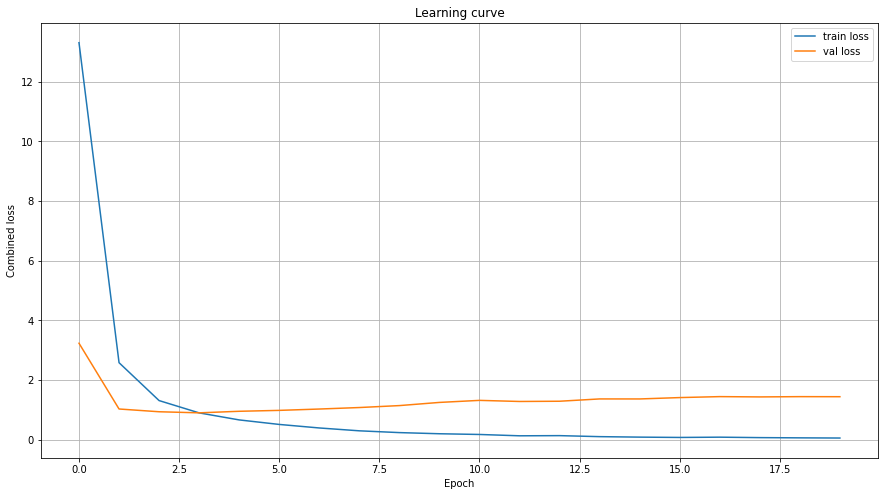

In [5]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (15,8))
plt.plot(trainloss, label='train loss')
plt.plot(valloss, label='val loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Combined loss')
plt.title('Learning curve')
plt.show()

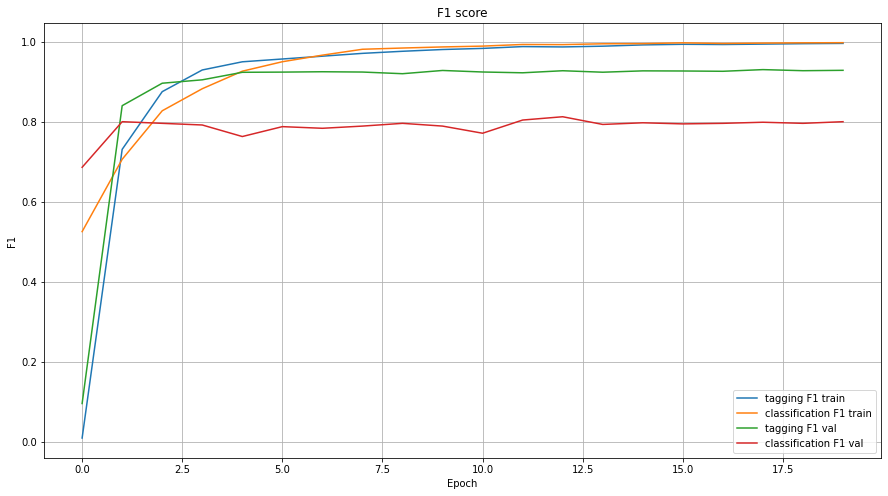

In [7]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (15,8))
plt.plot(F1_tagging, label='tagging F1 train')
plt.plot(F1_classification, label='classification F1 train')
plt.plot(val_F1_tagging, label='tagging F1 val')
plt.plot(val_F1_classification, label='classification F1 val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('F1 score')
plt.show()